(chap_formation_noise)=
# Noise

:::{admonition} Chapter outline
:class: tip

* There are two main types of noise in fluorescence microscopy: **photon noise & read noise**
* **Photon noise** is _signal-dependent_, varying throughout an image
* **Read noise** is _signal-independent_, and depends upon the detector
* **Detecting more photons** reduces the impact of both noise types
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

We could reasonably expect that a noise-free microscopy image should look pleasantly smooth, not least because the convolution with the PSF has a blurring effect that softens any sharp transitions.
Yet in practice raw fluorescence microscopy images are not smooth.
They are always, to a greater or lesser extent, corrupted by noise.
This appears as a random 'graininess' throughout the image, which is often strong enough to obscure details.

This chapter considers the nature of the noisiness, where it comes from, and what can be done about it.
Before starting, it may be helpful to know the one major lesson of this chapter for the working microscopist is simply:

:::{tip}
**If you want to reduce noise, you need to detect more photons**
:::

This general guidance applies in the overwhelming majority of cases when a good quality microscope is functioning properly.
Nevertheless, it may be helpful to know a bit more detail about why -- and what you might do if detecting more photons is not feasible.

(sec_noise_background)=
### Background

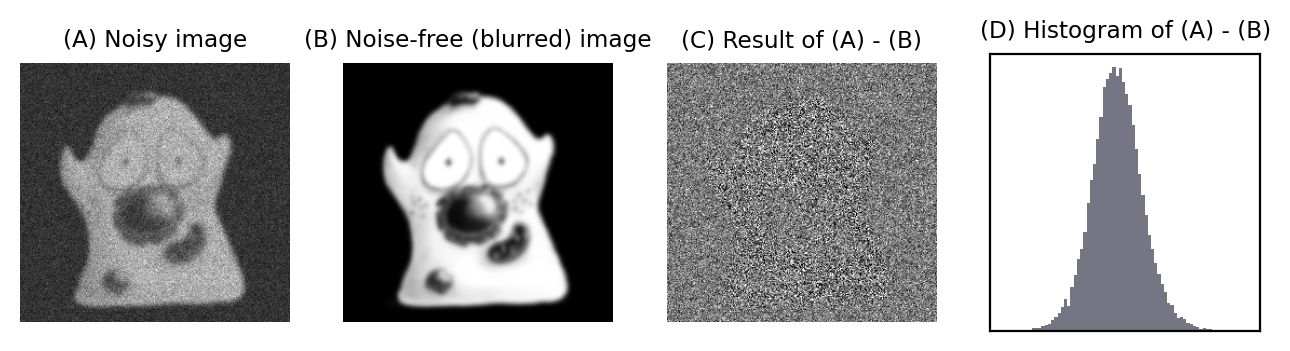

In [2]:
"""
Visualize an image with/without noise.
The point is that noise comprises random positive/negative values,
usually with a predictable distribution.

(Of course, in the simulation we can make sure that's the case...
but real-world investigations support the basis of these simulations)
"""

# Load image & normalize between 0 and 1
im = load_image('happy_cell.tif').astype(np.float32)
im = im - im.min()
im = im / im.max()

# Adjust the intensities a bit.
# This allows us to balance the brightness signal and the background,
# which helps because for very low signals Poisson noise looks weirder -
# and right now we don't want to be distracted by odd-looking histograms.
# We'll cover that later.
background = 40
max_signal = 100
im = background + im * (max_signal - background)

# Blur (to simulate point spread function)
sigma = 2
im = ndimage.gaussian_filter(im, sigma)

# Add Poisson noise (for realism)
rng = np.random.default_rng(100)
im_noisy = rng.poisson(im)

# Compute the difference between the noisy image & ideal image
im_diff = im_noisy - im

# Show images
fig = create_figure(figsize=(8, 1.8))

show_image(im_noisy, title='(A) Noisy image', pos=141)
show_image(im, title='(B) Noise-free (blurred) image', pos=142)
show_image(im_diff, title='(C) Result of (A) - (B)', clip_percentile=1, pos=143)
show_histogram(im_diff.flatten(), xlabel=None, ylabel=None, title='(D) Histogram of (A) - (B)', pos=144)
plt.xticks([])
plt.yticks([])

# plt.tight_layout()

glue_fig('fig_noise_demo', fig)

```{glue:figure} fig_noise_demo
---
align: center
name: fig-noise_demo
---
Illustration of the difference between a noisy image that we can record (A), and the noise-free image we would prefer (B). The 'noise' itself is what would be left over if we subtracted one from the other \(C). The histogram in (D) resembles a normal (i.e. Gaussian) distribution and shows that the noise consists of positive and negative values, with a mean of 0.
```


In general, we can assume that noise in fluorescence microscopy images has the following three characteristics, illustrated in {numref}`fig-noise_demo`:


1.  **Noise is random** -- For any pixel, the noise is a random positive or negative number added to the 'true value' the pixel should have.
2.  **Noise is independent at each pixel** -- The value of the noise at any pixel does not depend upon where the pixel is, or what the noise is at any other pixel.
3.  **Noise follows a particular distribution** -- Each noise value can be seen as a _random variable_ drawn from a particular distribution.
If we have enough noise values, their histogram would resemble a plot of the distribution [^fn_1].

[^fn_1]: Specifically its probability density or mass function -- which for a Gaussian distribution is the familiar bell curve.

There are many different possible noise distributions, but we only need to consider the **Poisson** and **Gaussian** cases.
No matter which of these we have, the most interesting distribution parameter for us is the **standard deviation**.
Assuming everything else stays the same, if the standard deviation of the noise is higher then the image looks worse ({numref}`fig-gaussian_hists`).

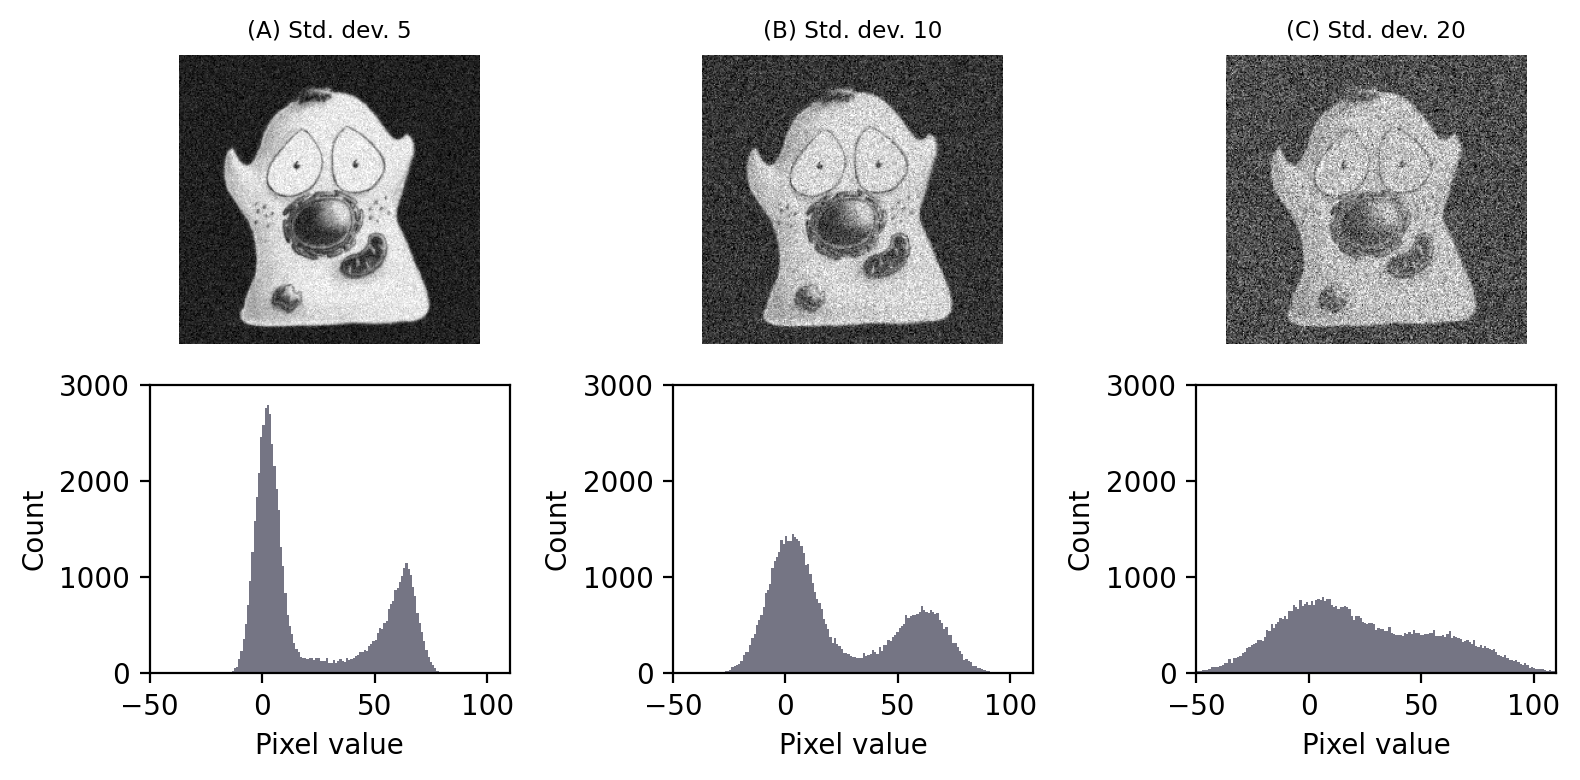

In [3]:
"""
Demonstrate that noise with a higher standard deviation makes an image
look worse, if all else stays the same (i.e. lower signal-to-noise ratio).
"""

# Load image
im = load_image('happy_cell.tif').astype(np.float32)

# Add noise with different standard deivations
rng = np.random.default_rng(200)

im_noise_5 = im + rng.normal(size=im.shape) * 5
im_noise_10 = im + rng.normal(size=im.shape) * 10
im_noise_20 = im + rng.normal(size=im.shape) * 20

fig = create_figure(figsize=(8, 4))

show_image(im_noise_5, title='(A) Std. dev. 5', clip_percentile=1, pos=231)
show_image(im_noise_10, title='(B) Std. dev. 10', clip_percentile=1, pos=232)
show_image(im_noise_20, title='(C) Std. dev. 20', clip_percentile=1, pos=233)

# Easier to show histograms with same settings in a loop
pos = 234
for im_noise in [im_noise_5, im_noise_10, im_noise_20]:
    show_histogram(im_noise.flatten(), pos=pos)
    plt.xlim([-50, 110])
    plt.ylim([0, 3000])
    pos += 1

plt.tight_layout()
glue_fig('fig_gaussian_hists', fig)

```{glue:figure} fig_gaussian_hists
---
align: center
name: fig-gaussian_hists
---
Gaussian noise with different standard deviations added to an image. Noise with a higher standard deviation has a worse effect when added to an image. Its impact can be seen in the histogram, as the distribution of foreground and background pixels overlap more -- which is problematic for things like [thresholding](chap_thresholding).
```

The reason we will consider two distributions is that there are two main types of noise for us to worry about:


1.  **Photon noise**, from the emission (and detection) of the light itself.
This follows a Poisson distribution, for which _the standard deviation changes with the local image brightness_.
2.  **Read noise**, arising from inaccuracies in quantifying numbers of detected photons.
This follows a Gaussian distribution, for which _the standard deviation stays the same throughout the image_.

Therefore the noise in the image is really the result of adding two [^fn_2] separate random components together.
In other words, to get the value of any pixel $P$ you need to calculate the sum of the 'true' (noise-free) value $T$, a random photon noise value $N_p$, and a random read noise value $N_r$, i.e.


[^fn_2]: Actually more.
But the two mentioned here are usually by far the most significant, and it does not matter to our model at all if they contain various other sub-components.
The important fact remains that there is some noise that varies throughout the image, and some that does not.


```{math}
P = T + N_p + N_r
```

In this case, we have $P$ in the image but we want $T$.
Unfortunately, we don't know precisely what the random values $N_p$ and $N_r$ are.

Finally, some useful maths:
* Suppose we add two random noisy values together. Both are independent and drawn from distributions (Gaussian or Poisson) with standard deviations $\sigma_1$ and $\sigma_2$.
The result is a third random value, drawn from a distribution with a standard deviation $\sqrt{\sigma_1^2 + \sigma_2^2}$.
* If we multiply a noisy value from a distribution with a standard deviation $\sigma_1$ by $k$, the result is noise from a distribution with a standard deviation $k\sigma_1$.

These are all my most important noise facts, upon which the rest of this chapter is built.
We will begin with Gaussian noise because it's easier to work with, found in many applications, and widely studied in the image processing literature.
However, in _most_ fluorescence images photon noise is the more important factor.
Fortunately, there's a close relationship between the Gaussian and Poisson noise -- and it's even possible to convert the latter to behave like the former.

## Gaussian noise

Gaussian noise is a common problem in fluorescence images acquired using a CCD camera (see {ref}`chap_microscope_types`).
It arises at the stage of quantifying the number of photons detected for each pixel. Quantifying photons is hard to do with complete precision, and the result is likely to be wrong by at least a few photons.
This error is the read noise.

Read noise typically follows a Gaussian distribution and has a mean of zero: this implies there is an equal likelihood of over or underestimating the number of photons.
Furthermore, according to the properties of Gaussian distributions, we should expect around ~68% of measurements to be ±1 standard deviation from the true, read-noise-free value.
If a detector has a low read noise standard deviation, this is then a good thing: it means the error should be small.

### Signal-to-Noise Ratio (SNR)

Read noise is said to be **signal independent**: its standard deviation is constant, and does not depend upon how many photons are being quantified.
However, the extent to which read noise is a problem probably _does_ depend upon the number of photons.
For example, if we have detected 20 photons, a noise standard deviation of 10 photons is huge; if we have detected 10 000 photons, it's likely not so important.

A better way to assess the noisiness of an image is then the ratio of the interesting component of each pixel (called the **signal**, which is here what we would ideally detect in terms of photons) to the noise standard deviation, which is known as the __Signal-to-Noise Ratio__ [^fn_3]:

[^fn_3]: This is one definition of SNR.
Many other definitions appear in the literature, leading to different values.
The fact that any interesting image will vary in brightness in different places means that the SNR is not necessarily the same at all pixels -- therefore computing it in practice involves coming up with some summary measurement for the whole image.
This can be approached differently, but the general principle is always to compare how much noise we have relative to interesting things: where higher is better.

```{math}
:label: eqn-snr
\textrm{SNR} = \frac{\textrm{Signal}}{\textrm{Noise standard deviation}}
```


````{tab-set}

```{tab-item} Question


Calculate the SNR in the following cases:


* We detect an average of 10 photons, read noise standard deviation 1 photon
* We detect an average of 100 photons, read noise standard deviation 10 photons
* We detect an average of 1000 photons, read noise standard deviation 10 photons

For the purposes of this question, you should assume that read noise is the only noise present (ignore photon noise).
```


```{tab-item} Answer


* We detect an average of 10 photons, read noise std. dev. 1 photon: _SNR = 10_
* We detect an average of 100 photons, read noise std. dev. 10 photons: _SNR = 10_
* We detect an average of 1000 photons, read noise std. dev. 10 photons: _SNR = 100_

The noise causes us a similar degree of uncertainty in the first two cases.
In the third case, the noise is likely to be less problematic: higher SNRs are good.
```

````

:::{admonition} Exploring noise
:class: tip

I find the best way to learn about noise is by creating simulation images, and exploring their properties through making and testing predictions.

The figures in this chapter are generated using such simulations in Python.
If you want to do something similar in ImageJ, you can add Gaussian noise with a fixed standard deviation to any image using {menuselection}`Process --> Noise --> Add Specified Noise...`.

If needed, you can create an empty 32-bit image with {menuselection}`File --> New --> Image...` add noise to get an image containing nothing but noise.
:::

### Adding & averaging noisy images

{ref}`At the beginning of this chapter<sec_noise_background>`, I stated how to calculate the new standard deviation of the noise whenever two noisy pixels are added together:

* Square the original noise standard deviation to get the variance for each pixel
* Add the variances
* Take the square root of the result

Suppose that we have two (independent) images with the same Gaussian noise standard deviation, let's say 5.
Applying this calculation, if we add the images together then the noise standard deviation of the resulting image is

$$
\sqrt{5^2 + 5^2} = \sqrt{50} \approx 7.07
$$

The noise standard deviation of the resulting image is higher.

We might expect that the sum of two noisy image is therefore *worse*: we have increased the noise.
*However*, we need to remember that the signal is also higher: in fact, it has been doubled (because we added two similar images).

If we want an output image with similar signal to the originals, we should *average* the corresponding pixel values instead of adding.
In this case, averaging is the same as adding, except that we divide by two.
When we do this, the noise standard deviation is also halved and becomes approximately 3.54 -- i.e. it is *lower* than in either of the original two images.

This matters, because it implies that if we were to average two independent noisy images of the same scene with similar SNRs, we would get a result that contains _less_ noise, i.e. a higher SNR.

But you shouldn't just take my word for it.
We can check that it really works by using a simulation.
{numref}`fig-fig_noise_sum` demonstrates this, and has a very practical implication: noise reduction by averaging images creates a better peak separation in the histogram.
This means it should usually give us an image that is more amenable to thresholding.

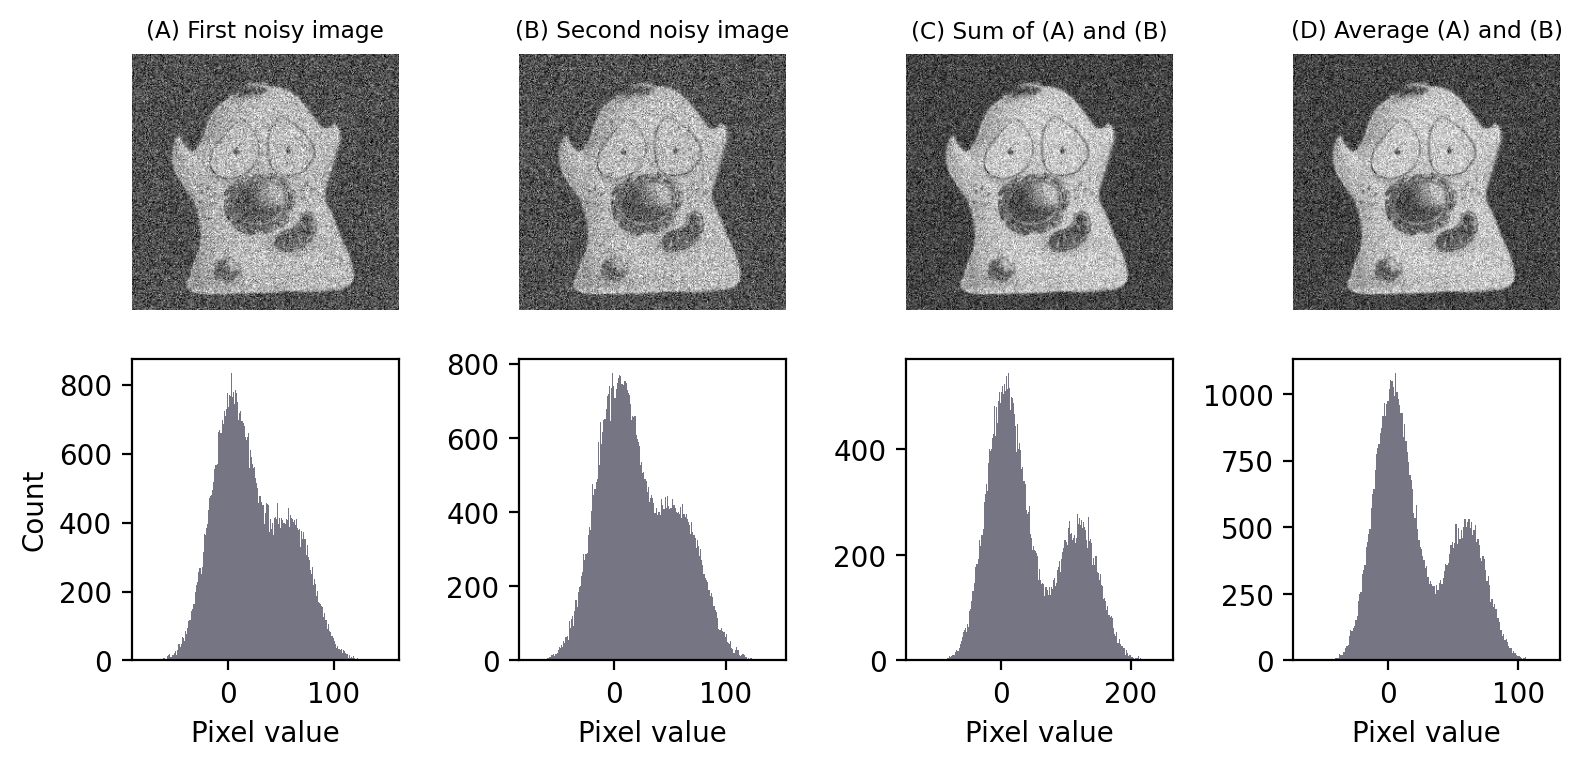

In [4]:
"""
Splitting one image to form two.
"""

# Load image
im = load_image('happy_cell.tif').astype(np.float32)

# Create two independeny noisy images
rng = np.random.default_rng(200)
im_noisy1 = im + rng.normal(scale=20, size=im.shape)
im_noisy2 = im + rng.normal(scale=20, size=im.shape)

# Average the images
im_sum = (im_noisy1 + im_noisy2)
im_averaged = im_sum / 2.0

fig = create_figure(figsize=(8, 4))

# Show the images and histograms
show_image(im_noisy1, clip_percentile=0.5, title="(A) First noisy image", pos=241)
show_image(im_noisy2, clip_percentile=0.5, title="(B) Second noisy image", pos=242)
show_image(im_sum, clip_percentile=0.5, title="(C) Sum of (A) and (B)", pos=243)
show_image(im_averaged, clip_percentile=0.5, title="(D) Average (A) and (B)", pos=244)

show_histogram(im_noisy1, pos=245)
show_histogram(im_noisy2, ylabel=None, pos=246)
show_histogram(im_sum, ylabel=None, pos=247)
show_histogram(im_averaged, ylabel=None, pos=248)

plt.tight_layout()

glue_fig('fig_noise_sum', fig)

```{glue:figure} fig_noise_sum
---
align: center
name: fig-fig_noise_sum
---
Adding and averaging two independent images with Gaussian noise.
Both adding and averaging give an image with an improved SNR, as can be seen in the improved separation between the histogram peaks.
```

### Adding & averaging within an image

All this means that *if* can acquire the same image multiple times, then averaging our different images would give a result with reduced noise.

Of course, we don't usually have multiple independent images of everything we might want to analyze.
Instead, we just have one image.
However, we can explore the idea by splitting a single image into two -- provided we are willing to sacrifice some spatial resolution.

If we take the pixels from every second column of the image, we can extract these and combine them to form another image that looks like a squished version of the original.
We can do the same process for all the columns we skipped -- thereby giving us two squished images, one from the even-numbered columns and one from the odd-numbered columns.

You can see in Figure {numref}`fig-fig_noise_split` that our squished images do look almost identical, because adjacent pixels usually do have very similar values -- apart from the differences caused by noise.
If we average these images together, these differences average out and we have another similar-looking image -- but with reduced noise.

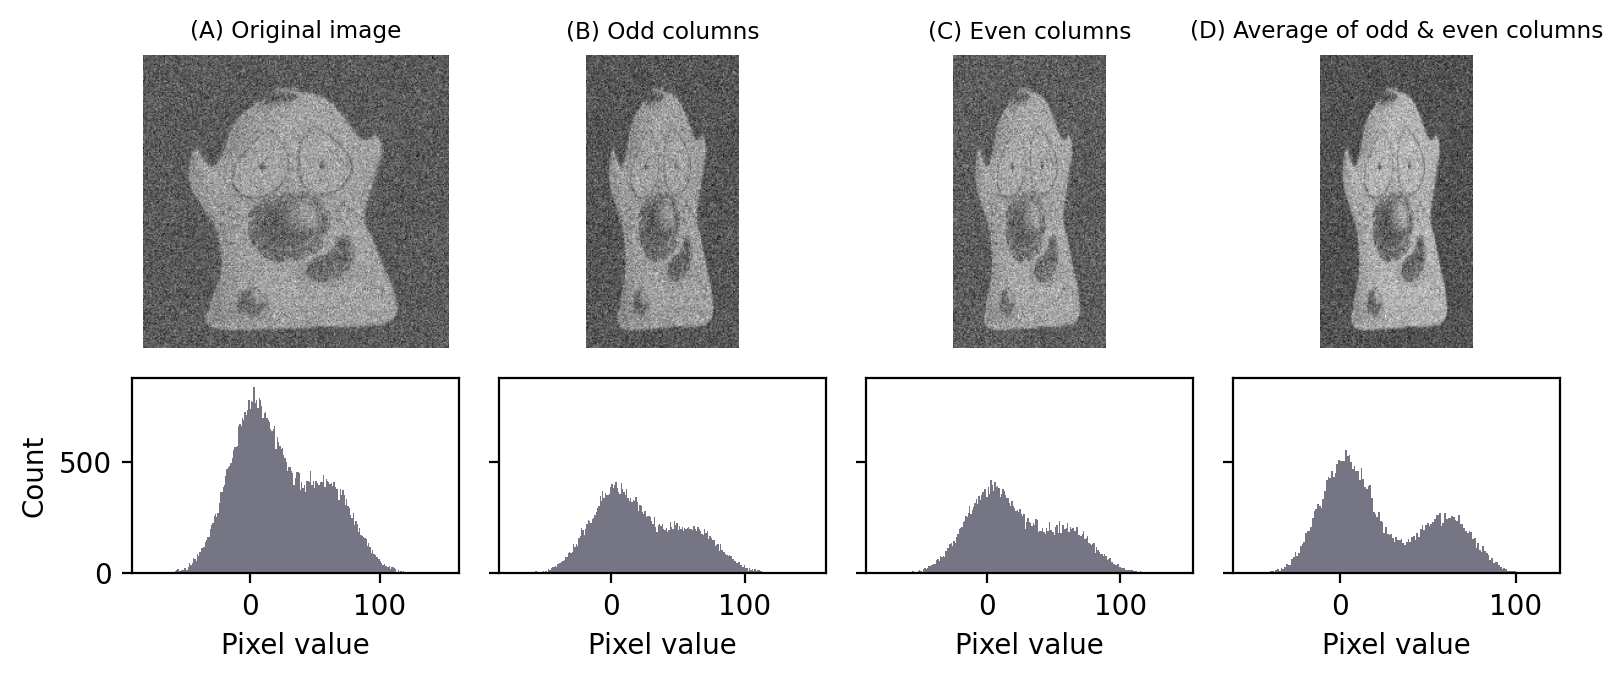

In [5]:
"""
Splitting one image to form two.
"""

# Load image
im = load_image('happy_cell.tif').astype(np.float32)

# Add noise
rng = np.random.default_rng(200)
im_noisy = im + rng.normal(size=im.shape) * 20

# Split left and right images
im_left = im_noisy[:, ::2]
im_right = im_noisy[:, 1::2]

# Average the images
im_averaged = (im_left + im_right) / 2.0

# fig = create_figure(figsize=(8, 3))
fig, axs = plt.subplots(nrows=2, ncols=4, dpi=200,
                        gridspec_kw={'height_ratios':[1.5,1]},
                        sharey='row',
                        figsize=(8, 3.5))

# Pad images for display

show_image(im_noisy, title="(A) Original image", axes=axs[0][0])
show_image(im_left, title="(B) Odd columns", axes=axs[0][1])
show_image(im_right, title="(C) Even columns", axes=axs[0][2])
show_image(im_averaged, title="(D) Average of odd & even columns", axes=axs[0][3])

show_histogram(im_noisy, axes=axs[1][0])
show_histogram(im_left, ylabel=None, axes=axs[1][1])
show_histogram(im_right, ylabel=None, axes=axs[1][2])
show_histogram(im_averaged, ylabel=None, axes=axs[1][3])

plt.tight_layout()

glue_fig('fig_noise_split', fig)

```{glue:figure} fig_noise_split
---
align: center
name: fig-fig_noise_split
---
Creating two images from one by taking even and odd-numbered columns. If we then average our two images, noise is reduced. The difference is subtle, but can be seen in the better separation of the peaks in the histogram.
```

Of course, this trick has an obvious downside: the squishing is undesirable.
Fortunately, we can avoid it simply by averaging adjacent columns but not splitting them into separate image.
Then we can do the same with adjacent rows.
And perhaps even adjacent diagonals, if we wish.

This is *precisely* the idea underlying our use of a [3×3 mean filter to reduce noise](chap_filters): we don't have independent images to average, so we average within an image instead ({numref}`fig-noise_filt_averaging`).

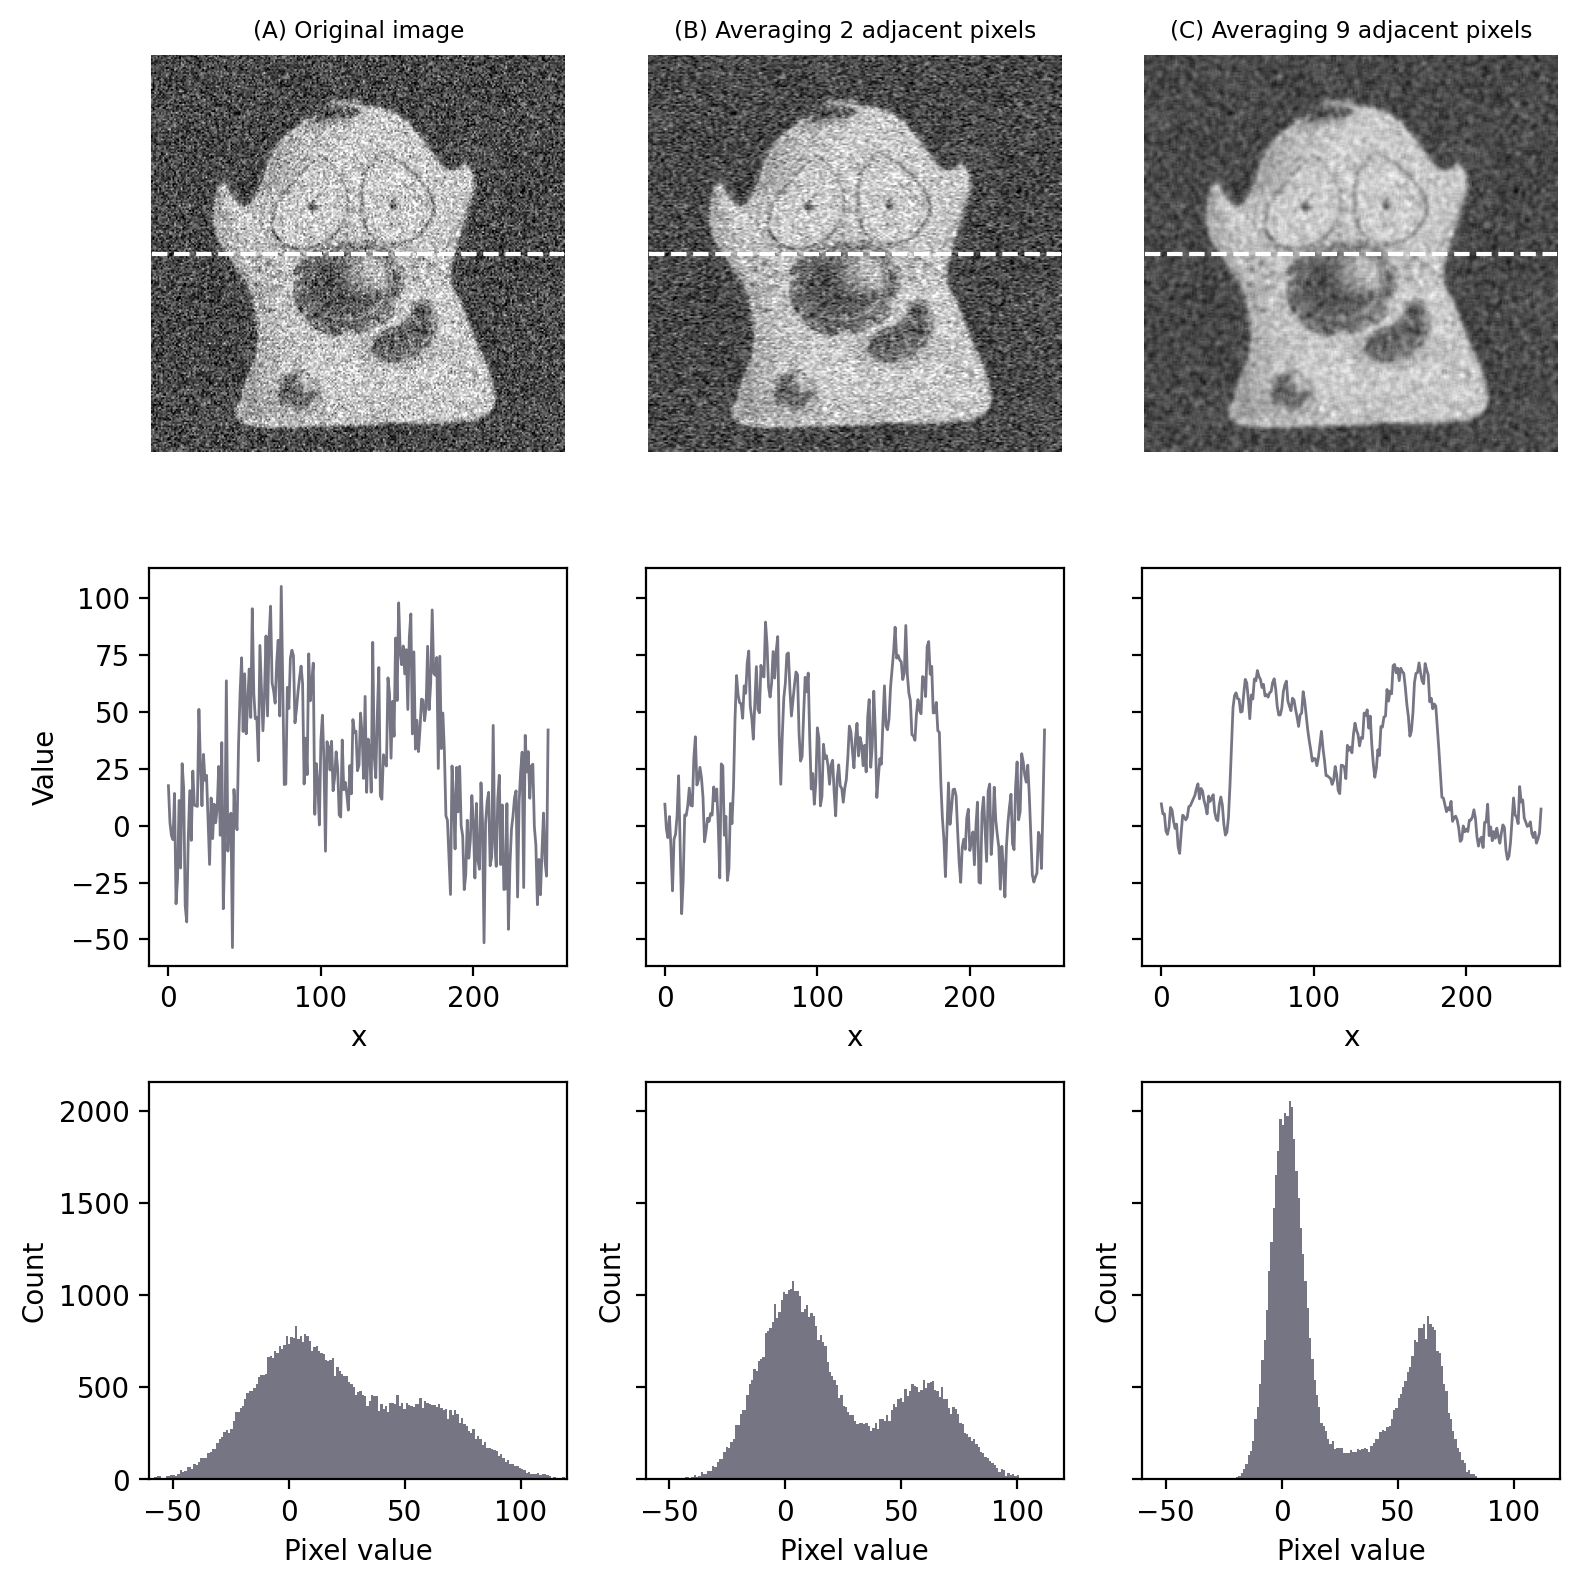

In [6]:
"""
Show the effect of averaging pixels.
"""

# Load image
im = load_image('happy_cell.tif').astype(np.float32)

# If we have fewer pixels, the differences will be easier to see
# im = im[::2, ::2]

# Add noise
rng = np.random.default_rng(200)
im_noisy = im + rng.normal(size=im.shape) * 20

# Compute the average of 2 adjacent pixels
kernel_2 = np.asarray([1, 1, 0]).reshape((1, 3)) / 2.0
im_noisy_2 = ndimage.convolve(im_noisy, kernel_2)

# Compute the average of 9 adjacent pixels
kernel_9 = np.ones((3, 3)) / 9.0
im_noisy_9 = ndimage.convolve(im_noisy, kernel_9)

# Compute same display settings to use for all images
im_args = dict(
    vmin = np.percentile(im_noisy, 2),
    vmax = np.percentile(im_noisy, 98)
)

# fig = create_figure(figsize=(8, 6))
fig, ax = plt.subplots(3, 3, sharey='row', dpi=200, figsize=(8, 8))

row = im.shape[0] // 2
line_args = ([0, im.shape[1]-1], [row, row], 'w--')

pos = 331

show_image(im_noisy, title='(A) Original image', **im_args, pos=pos)
plt.plot(*line_args)
pos += 1

show_image(im_noisy_2, title='(B) Averaging 2 adjacent pixels', **im_args, pos=pos)
plt.plot(*line_args)
pos += 1

show_image(im_noisy_9, title='(C) Averaging 9 adjacent pixels', **im_args, pos=pos)
plt.plot(*line_args)
pos += 1

show_plot(im_noisy[row, :], xlabel='x', ylabel='Value', linewidth=1, pos=pos)
pos += 1

show_plot(im_noisy_2[row, :], xlabel='x', linewidth=1, pos=pos)
pos += 1

show_plot(im_noisy_9[row, :], xlabel='x', linewidth=1, pos=pos)
pos += 1

show_histogram(im_noisy, pos=pos)
plt.xlim([-60, 120])
pos += 1
show_histogram(im_noisy_2, pos=pos)
plt.xlim([-60, 120])
pos += 1
show_histogram(im_noisy_9, pos=pos)
plt.xlim([-60, 120])


plt.tight_layout()

glue_fig('fig_filt_averaging', fig)

```{glue:figure} fig_filt_averaging
---
align: center
name: fig-noise_filt_averaging
---
Noise reduction by averaging adjacent pixels. Even though the overall appearance of the image has not changed much, the histograms indicate a much bigger separation of the foreground and background -- meaning that thresholds are more likely to work well. In (C), the result is equivalent to applying a 3×3 mean filter.
```

Hopefully this discussion helps build your intuition as to *why* filters are able to reduce Gaussian noise.
In the next section, we'll see how many of the same ideas apply to Poisson noise as well.


## Poisson noise

In 1898, Ladislaus Bortkiewicz published a book entitled _The Law of Small Numbers_.
Among other things, it included a now-famous analysis of the number of soldiers in different corps of the Prussian cavalry who were killed by being kicked by a horse, measured over a 20-year period. Specifically, he showed that these numbers follows a **Poisson distribution**.

This distribution, introduced by Siméon Denis Poisson in 1838, gives the probability of an event happening a certain number of times, given that we know (1) the average rate at which it occurs, and (2) that all of its occurrences are independent.
However, the usefulness of the Poisson distribution extends far beyond gruesome military analysis to many, quite different applications -- including the probability of photon emission, which is itself inherently random.

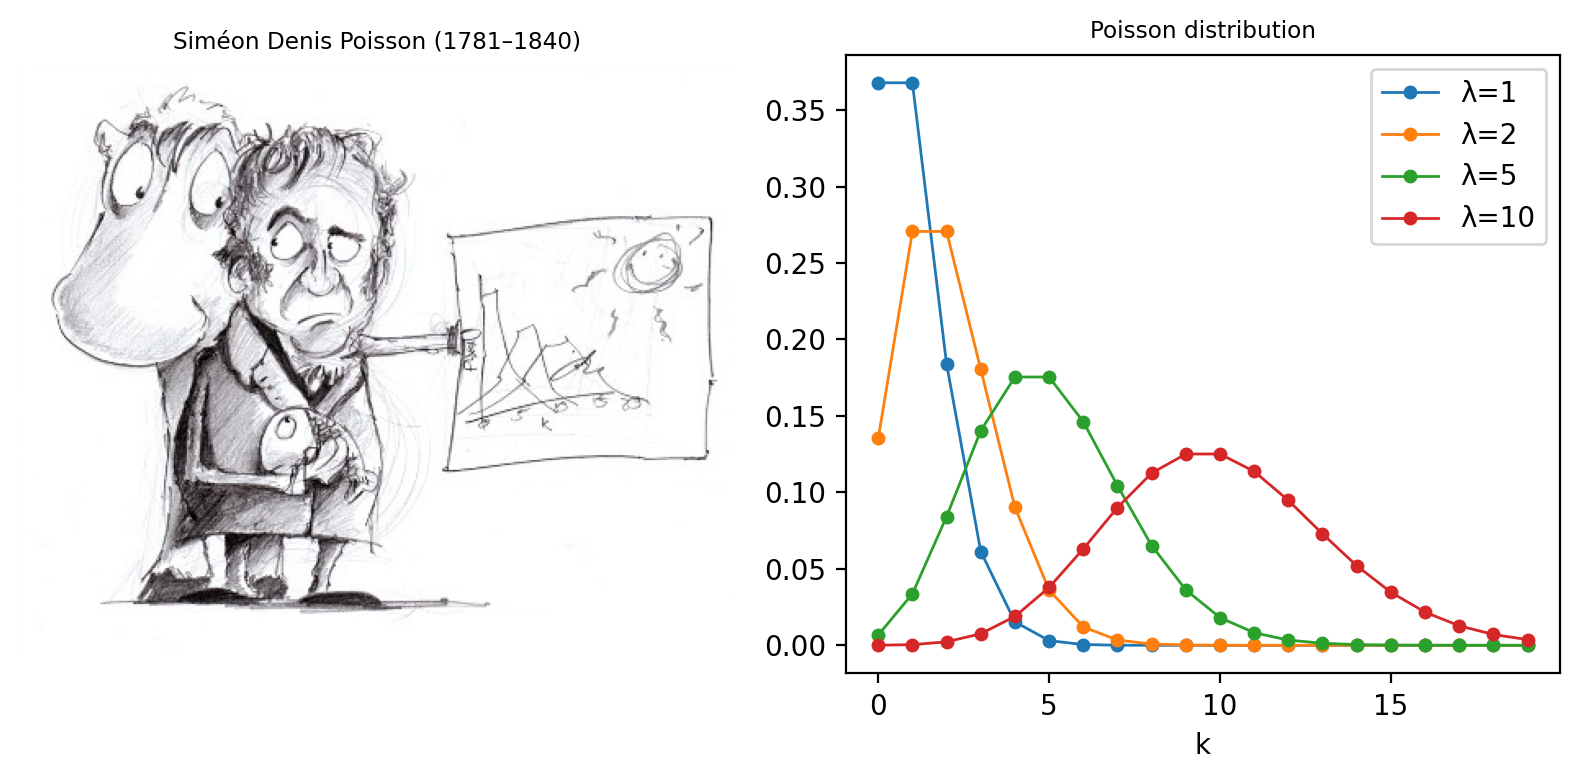

In [7]:
"""
Show Probability mass function for the Poisson distribution.
"""

fig = create_figure(figsize=(8, 4))

show_image('images/Poisson.jpg', title='Siméon Denis Poisson (1781–1840)', pos=121)

from scipy import stats
k = np.arange(20)
plt.subplot(122)
plot_params = dict(
    color=None,
    marker='o',
    markersize=4,
    title='Poisson distribution'
)
for mu in [1, 2, 5, 10]:
    poisson = stats.poisson(mu)
    show_plot(k, poisson.pmf(k), **plot_params, label=f'λ={mu}')
plt.legend()
plt.xlabel('k')

plt.tight_layout()

# show_image('images/maths_pmf_poisson.png', title='Poisson distribution', pos=122)
glue_fig('fig_noise_poisson', fig)

```{glue:figure} fig_noise_poisson
---
align: center
name: fig-poisson
---
Siméon Denis Poisson and his distribution. (A) Poisson is said to have been extremely clumsy and uncoordinated with his hands. This contributed to him giving up an apprenticeship as a surgeon and entering mathematics, where the problem was less debilitating -- although apparently this meant his diagrams tended not to very well drawn (see https://mathshistory.st-andrews.ac.uk/Biographies/Poisson/). (B) The 'Probability Mass Function' of the Poisson distribution for several different values of λ. This allows one to see for any 'true signal' λ the probability of actually counting any actual value k. Although it's more likely that one will count exactly k = λ than any other possible k, as λ increases the probability of getting precisely this value becomes smaller and smaller.
```


Suppose that, on average, a single photon will be emitted from some part of a fluorescing sample within a particular time interval.
The randomness entails that we cannot say for sure what will happen on any one occasion when we look; sometimes one photon will be emitted, sometimes none, sometimes two, occasionally even more.
What we are really interested in, therefore, is not precisely _how many_ photons are emitted, which varies every time we look, but rather the _rate_ at which they would be emitted under fixed conditions, which is a constant.
The difference between the number of photons actually emitted and the true rate of emission is the **photon noise**.
The trouble is that keeping the conditions fixed might not be possible: leaving us with the problem of trying to figure out rates from single, noisy measurements.

### Signal-dependent noise

Clearly, since it's a rate that we want, we could get that with more accuracy if we averaged many observations: just like with Gaussian noise, averaging reduces photon noise.
Therefore, we can expect smoothing filters to work similarly for both noise types -- and they do.

The primary distinction between the noise types, however, is that Poisson noise is **signal-dependent**, and _does_ change according to the number of emitted (or detected) photons.
Fortunately, the relationship is simple: if the rate of photon emission is $\lambda$, the noise variance is also $\lambda$, and the noise standard deviation is $\sqrt{\lambda}$.

This is not really as unexpected as it might first seem (see {numref}`fig-fishing`).
It can even be observed from a very close inspection of {numref}`fig-noise_neuron`, in which the increased variability in the neuron causes its ghostly appearance even in an image that ought to consist (almost) exclusively of noise.

```{figure} images/fishing.jpg
---
align: center
width: 50%
name: fig-fishing
---
__'The standard deviation of photon noise is equal to the square root of the expected value.'__ To understand this better, it may help to imagine a fisherman, fishing many times at the same location and under the same conditions. If he catches 10 fish on average, it would be quite reasonable to catch 7 or 13 on any one day -- while 20 would be exceptional. If, however, he caught 100 on average, then it would be unexceptional if he caught 90 or 110 on a particular day, although catching only 10 would be strange (and presumably disappointing). Intuitively, the range of values that would be considered likely is related to the expected value. If nothing else, this imperfect analogy may at least help remember the name of the distribution that photon noise follows.
```

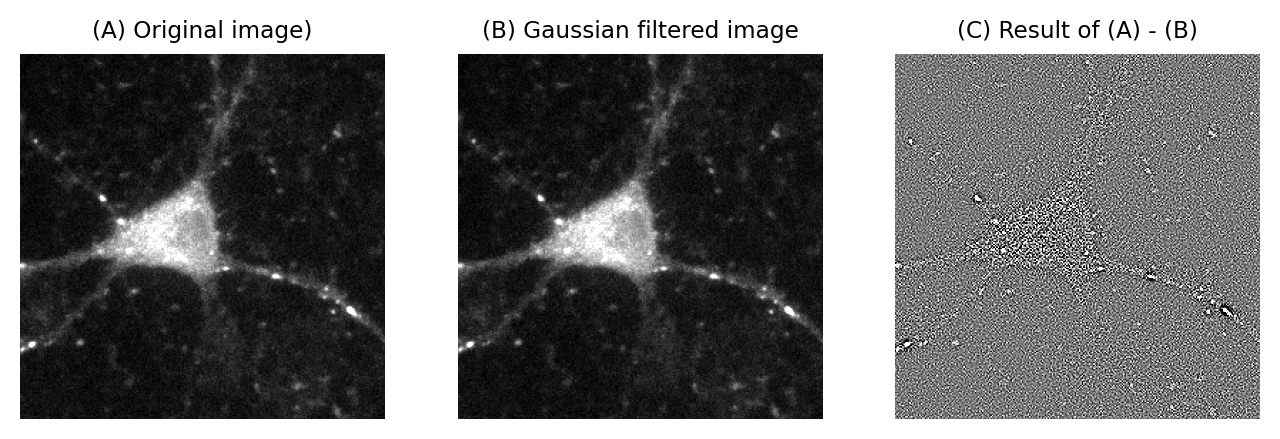

In [8]:
fig = create_figure(figsize=(8, 4))

r = 100
c = 100
s = 256
im = load_image('Rat_Hippocampal_Neuron.zip').astype(np.float32)[0, r:r+s, c:c+s]

im2 = ndimage.gaussian_filter(im, sigma=0.25)
im_diff = im - im2
show_image(im, clip_percentile=0.5, title='(A) Original image)', pos=131)
show_image(im2, clip_percentile=0.5, title='(B) Gaussian filtered image', pos=132)
show_image(im_diff, clip_percentile=5, title='(C) Result of (A) - (B)', pos=133)

glue_fig('fig_noise_neuron', fig)

```{glue:figure} fig_noise_neuron
---
align: center
name: fig-noise_neuron
---
A demonstration that Poisson noise changes throughout an image. (A) Part of a fluorescence microscopy image. (B) A Gaussian filtered version of (A) using a very small filter ($\sigma$=0.25).
Gaussian filtering reduces the noise in an image by replacing each pixel with a weighted average of neighboring pixels (see {ref}`chap_filters`). \(C) The difference between the original and filtered image contains the noise that the filtering removed. The brighter areas in the original image are still visible in this 'noise image' as regions of increased variability. This is partly an effect of Poisson noise having made the noise standard deviation larger in the brighter parts of the acquired image.
```


`````{tab-set}

````{tab-item} Question


The formula for the probability mass function of the Poisson distribution is:

```{math}
:label: eqn-poisson
\mathcal{P}(\lambda) \sim \frac{e^{-\lambda}\lambda^{k}}{k!}
```

where


* $\lambda$ is the mean rate of occurrence of the event (i.e.
the noise-free photon emission rate we want)
* $k$ is an actual number of occurrences for which we want to compute the probability
* $k!$ is the _factorial_ of $k$ (i.e. $k \times (k-1) \times (k-2) \times ... \times 1$)

So if you know that the rate of photon emission is 0.5, for example, you can put $\lambda = 0.5$ into the equation and determine the probability of getting any particular (integer) value of $k$ photons.
Applying this, the probability of not detecting any photons ($k = 0$) is 0.6065, while the probability of detecting a single photon ($k = 1$) is $0.3033$.

What we know for sure is that we can't possibly detect 0.5 photons: we'll get an integer value, not 'part of a photon'.

Assuming the mean rate of photon emission is 1, use Equation {eq}`eqn-poisson` to calculate the probability of actually detecting 5 (which, at 5 times the true rate, would be an extremely inaccurate result).
How common do you suppose it is to find pixels that are so noisy in the background region of a dark image?
````


````{tab-item} Answer

The probability of detecting 5 photons is approximately 0.0031.

```{math}
\frac{e^{-1}}{5!} = \frac{1}{120e} = 0.0031
```

Although this is a very low probability, images contain so many pixels that one should expect to see such noisy values often.
For example, in a rather dark and dull 512×512 pixel image in which the average photon emission rate is 1, we would expect 800 pixels to have a value of 5 -- and two pixels even to have a value of 8.
The presence of isolated bright or dark pixels therefore usually tells us very little indeed, and it is only by processing the image more carefully and looking at surrounding values that we can (sometimes) discount the possibility these are simply the result of noise.
````

`````

### The SNR for Poisson noise

If the standard deviation of noise was the only thing that mattered, this would suggest that we are better not detecting much light: then the photon noise standard deviation is lower.
But the SNR is a much more reliable guide.
For noise that follows a Poisson distribution this is particularly easy to calculate.
Substituting into the formula for the SNR (Equation {eq}`eqn-snr`):

```{math}
\textrm{SNR}_{Poiss} = \frac{\lambda}{\sqrt{\lambda}} = \sqrt{\lambda}
```

Therefore **the SNR of photon noise is equal to the square root of the signal**!

This means that as the average number of emitted (and thus detected) photons increases, so too does the SNR. More photons &rarr; a better SNR, directly leading to the assertion

:::{important}
If you want to reduce photon noise, you need to detect more photons
:::

We can visualize this using a simulation that displays how an image and its histogram change over time as more photons are detected.

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/photon_noise.mp4" type="video/mp4">
</video>

This is really just the same as the insight that averaging reduces noise.
Averaging and summing have the same effect, differing only by a constant scale factor.

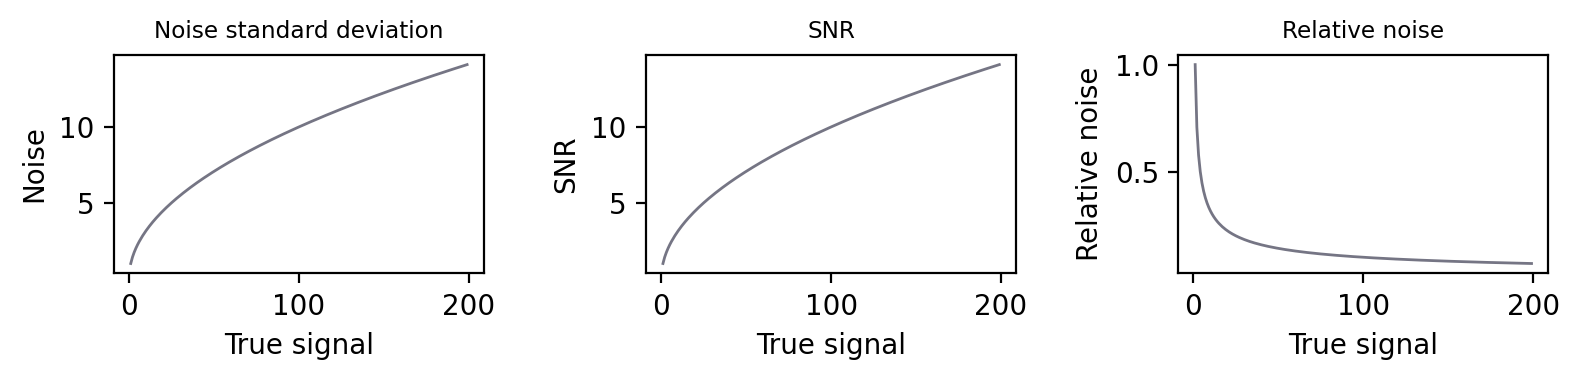

In [9]:
"""
Plots to show the signal to noise ratio and relative noise,
whenever the noise standard deviation is squal to the square root
of the signal (as with photon noise).

Basically, as the signal increases, so too do the SNR and the relative
noise decreases.
"""

signal = np.arange(1, 200)
noise = np.sqrt(signal)

fig = create_figure(figsize=(8, 2))

x_label = "True signal"
show_plot(signal, noise, xlabel=x_label, ylabel="Noise", title='Noise standard deviation', pos=131)
show_plot(signal, signal/noise, xlabel=x_label, ylabel="SNR", title='SNR', pos=132)
show_plot(signal, noise/signal, xlabel=x_label, ylabel="Relative noise", title='Relative noise', pos=133)

plt.tight_layout()

glue_fig('fig_noise_snr_plot', fig)

````{admonition} Why relativity matters: a simple example
:class: info

The SNR increases with the number of photons, even though the noise standard deviation increases too, because it's really _relative_ differences in the brightness in parts of the image that we are interested in.
Absolute numbers usually are of very little importance -- which is fortunate, since not all photons are detected.

Yet if you remain unconvinced that the noise standard deviation can get bigger while the situation gets better, the following specific example might help.
Suppose the true signal for a pixel is 4 photons.
Assuming the actual measured value is within one noise standard deviation of the proper result (which it will be, about 68% of the time), one expects it to be in the range 2–6.
The true signal at another pixel is twice as strong -- 8 photons -- and, by the same argument, one expects to measure a value in the range 5–11.
_The ranges for both pixels overlap!_ With photon counts this low, even if one pixel has twice the value of another, we often cannot discern with confidence that the *true*, noise-free value for both pixels would be different at all.

On the other hand, suppose the true signal for the first pixel is 100 photons, so we measure something in the range of 90–110.
The second pixel, still twice as bright, gives a measurement in the range 186–214. These ranges are larger, but crucially they are not even close to overlapping, so it's very easy to tell the pixels apart.
Thus the noise standard deviation alone is not a very good measure of how noisy an image is.
The SNR is much more informative: the simple rule is that higher is better.
Or, if that still does not feel right, you can turn it upside down and consider the noise-to-signal ratio (the _relative noise_), in which case lower is better ({numref}`fig-snr_plot`).

```{glue:figure} fig_noise_snr_plot
---
align: center
name: fig-snr_plot
---
For Poisson noise, the standard deviation increases with the square root of the signal. So does the SNR, with the result that plots (A) and (B) look identical. This improvement in SNR despite the growing noise occurs because the signal is increasing faster than the noise, and so the noise is relatively smaller. Plotting the relative noise (1/SNR) shows this effect \(C).
```

````

### Poisson noise & detection

So why should you care that photon noise is signal-dependent?

One reason is that it can make features of identical sizes and brightnesses easier or harder to detect in an image purely because of the local background.
This is illustrated in {numref}`fig-poisson_ramp`.

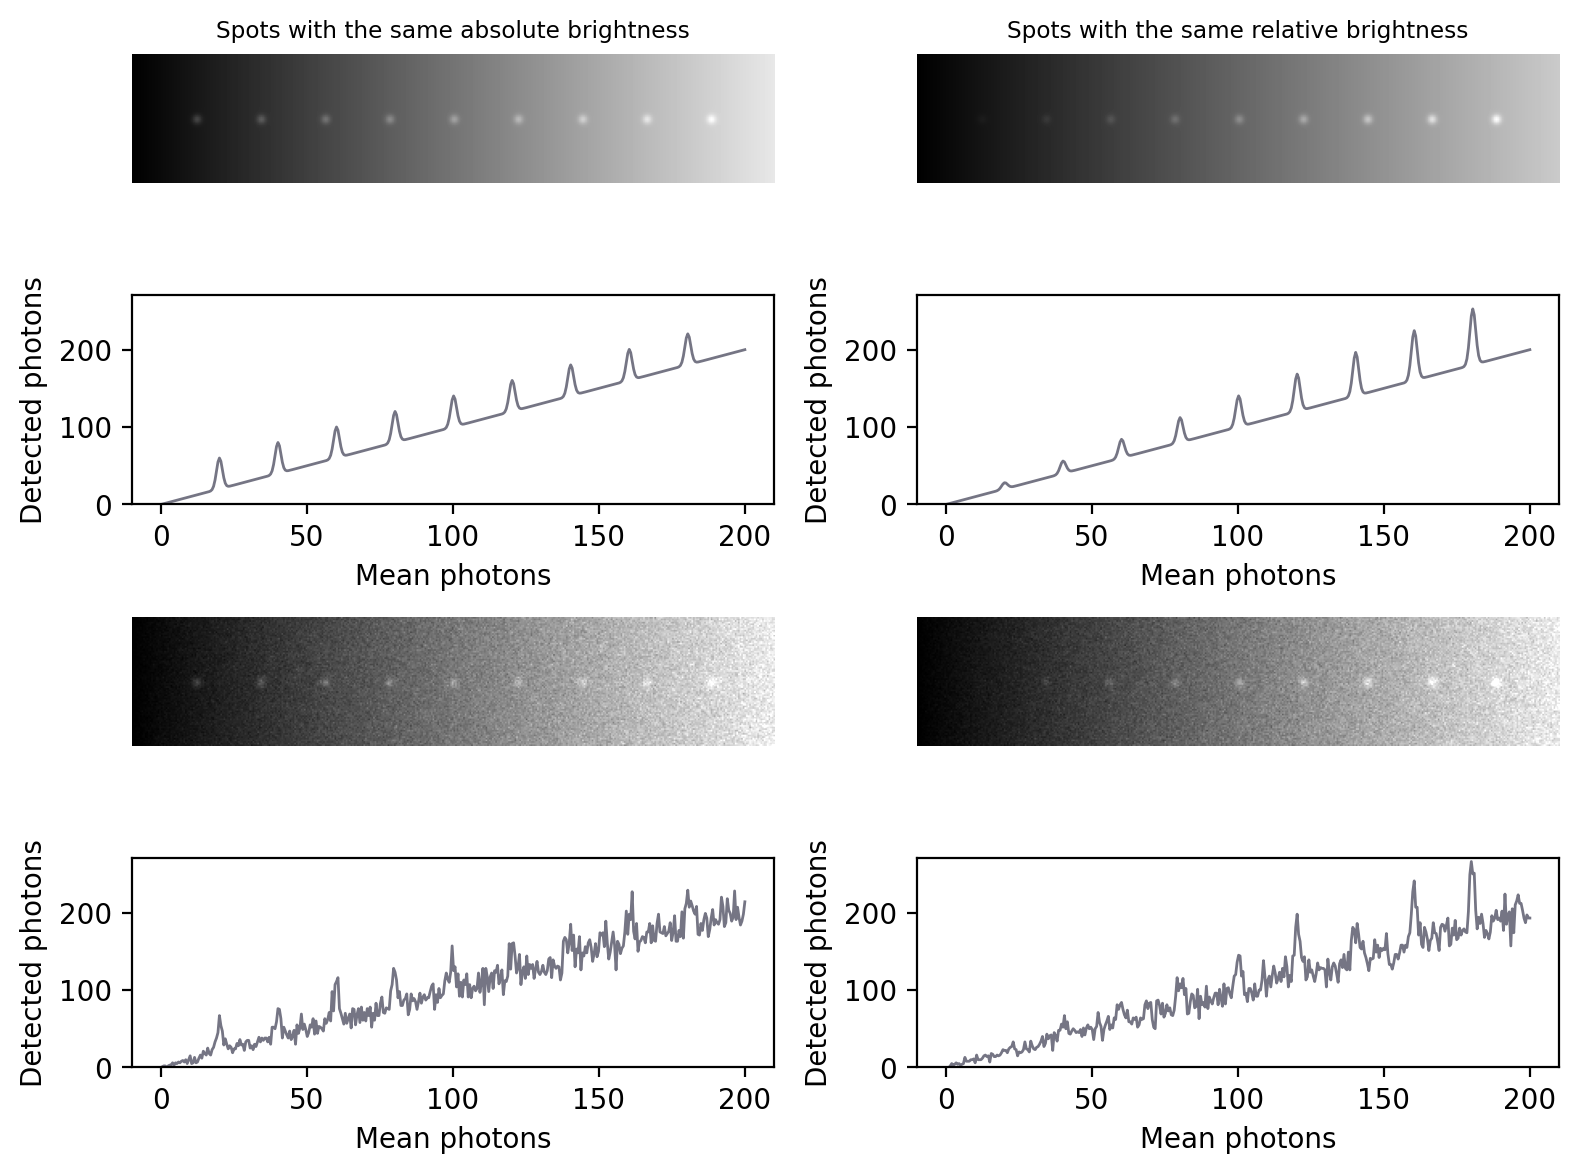

In [10]:
fig, axs = plt.subplots(figsize=(8, 6), dpi=200, sharex='col', sharey='row')

# Create a ramp image with increasing intensity
max_val = 200
width = 400
height = width // 5
spot_spacing = width // 10
spot_rel_intensity = 0.4
spot_abs_intensity = (max_val / 2) * spot_rel_intensity

x = np.linspace(0, max_val, width)
im_ramp = np.repeat(x.reshape((1, width)), height, axis=0)

# Create Gaussian spots, each with maximum intensity of 1
sigma = 2
row = height // 2
im_spots = np.zeros_like(im_ramp)
im_spots[row, spot_spacing::spot_spacing] = 1
im_spots = ndimage.gaussian_filter(im_spots, sigma)
im_spots = im_spots / im_spots.max()

# Add spots to ramp with same absolute or relative intensity
im_ramp_abs = im_ramp + im_spots * spot_abs_intensity
im_ramp_rel = im_ramp + im_ramp * im_spots * spot_rel_intensity

# Add poisson noise to each ramp
rng = np.random.default_rng(100)
im_ramp_abs_noise = rng.poisson(im_ramp_abs)
im_ramp_rel_noise = rng.poisson(im_ramp_rel)

plot_args = dict(
    xlabel='Mean photons',
    ylabel='Detected photons',
    ylim=[0, im_ramp_rel_noise.max()],
    xlim=None,
)

show_image(im_ramp_abs, title='Spots with the same absolute brightness', pos=421)
show_plot(x, im_ramp_abs[row,:], **plot_args, pos=423)
show_image(im_ramp_abs_noise, clip_percentile=0.5, pos=425)
show_plot(x, im_ramp_abs_noise[row,:], **plot_args, pos=427)

show_image(im_ramp_rel, title='Spots with the same relative brightness', pos=422)
show_plot(x, im_ramp_rel[row,:], **plot_args, pos=424)
show_image(im_ramp_rel_noise, clip_percentile=0.5, pos=426)
show_plot(x, im_ramp_rel_noise[row,:], **plot_args, pos=428)

plt.tight_layout()

glue_fig('fig_noise_poisson_ramp', fig)

```{glue:figure} fig_noise_poisson_ramp
---
align: center
name: fig-poisson_ramp
---
The signal-dependence of Poisson noise affects how visible (and therefore detectable) structures are in an image. (A) Nine spots of the same _absolute_ brightness are added to an image with a linearly increasing background _(top)_ and Poisson noise is added _(bottom)_. Because the noise variability becomes higher as the background increases, the spots in the darkest part of the image can be clearly seen in the profile but it's more difficult to discern spots in the brighter part. (B) Spots of the same brightness _relative_ to the background are added, along with Poisson noise. Because the noise is now relatively lower as the brightness increases, only the spots in the brightest part of the image can be seen, while those in the darker part are buried within the noise.
```


In general, if we want to see a fluorescence increase of a fixed number of photons, this is easier to do if the background is very dark.
But if the fluorescence increase is defined _relative_ to the background, it will be much easier to identify if the background is high.
Either way, when attempting to determine the number of any small structures in an image, for example, we need to remember that the numbers we will be able to detect will be affected by the background nearby.
Therefore results obtained from bright and dark regions might not be directly comparable.


````{tab-set}

```{tab-item} Practical


Open the images *mystery_noise_1.tif* and *mystery_noise_2.tif* in ImageJ.

Both are noisy, but in one the noise follows a Gaussian distribution (like read noise) and in the other it follows a Poisson distribution (like photon noise).
Which is which?

[![launch ImageJ.JS](https://ij.imjoy.io/assets/badge/launch-imagej-js-badge.svg)](https://ij.imjoy.io?open=https://github.com/bioimagebook/practical-data/blob/main/images/mystery_noise_1.tif&open=https://github.com/bioimagebook/practical-data/blob/main/images/mystery_noise_2.tif)
```


```{tab-item} Solution

The noise in *mystery_noise_1.tif* is Gaussian; the noise in *mystery_noise_2.tif* follows a Poisson distribution.
Since there are reasonably flat regions within the cell and background, I would test this by drawing a ROI within each and measuring the standard deviations.
Where these are similar, the noise is Gaussian; if there is a big difference, the noise is likely to be Poisson.

If no flat regions were available, I would try applying a gradient filter with the coefficients `-1 1 0`, and inspecting the results. Alternatively, I might try plotting a fluorescence profile or subtracting a very slightly smoothed version of each image.
```

````

## Combining noise sources

Combining our noise sources then, we can imagine an actual pixel value as being the sum of three values: the true rate of photon emission, the photon noise component, and the read noise component [^fn_5].
The first of these is what we want, while the latter two are random numbers that may be positive or negative.

[^fn_5]: For a fuller picture, gain and offset also need to be taken into consideration, see {ref}`chap_microscope_types`.

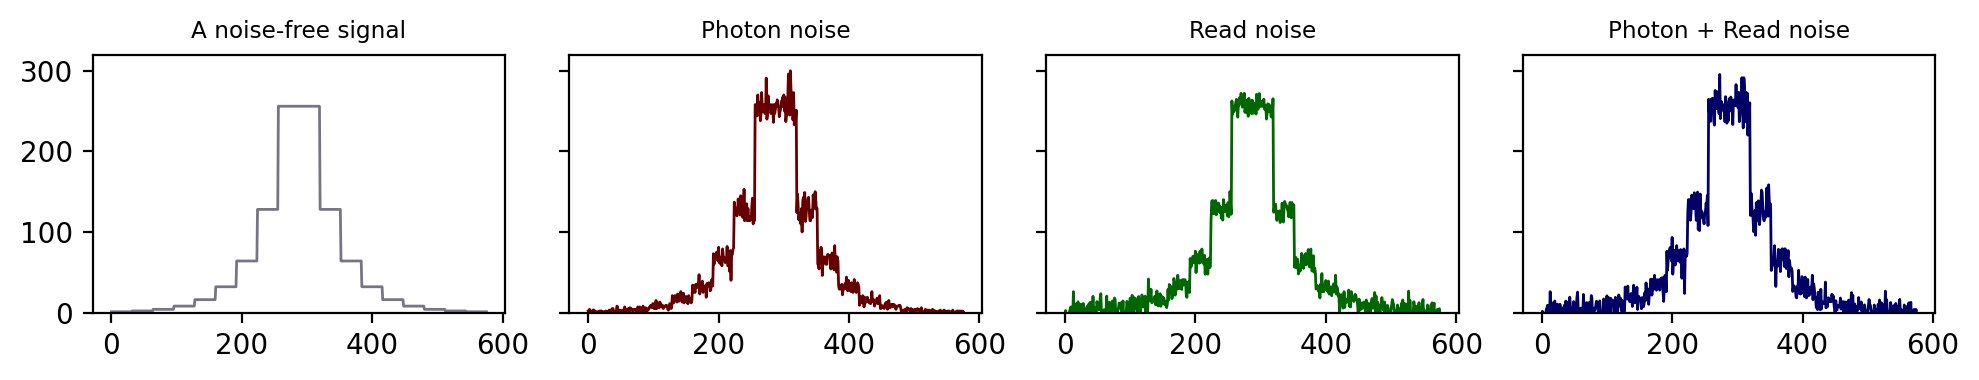

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2), dpi=200, sharey=True)

steps = np.power(2, np.arange(0, 9, 1))
steps = np.repeat(steps, 32, axis=0)
steps = np.concatenate([steps, steps[::-1]]).flatten()

rng = np.random.default_rng(100)
steps_poisson = rng.poisson(steps)
noise_gaussian = rng.normal(size=steps.shape) * 8
steps_gaussian = steps + noise_gaussian
steps_both = steps_poisson + noise_gaussian

ylim = [0, 320]
show_plot(steps, title='A noise-free signal', ylim=ylim, pos=141)
show_plot(steps_poisson, title='Photon noise', ylim=ylim, color=(0.4, 0, 0), pos=142)
show_plot(steps_gaussian, title='Read noise', ylim=ylim, color=(0, 0.4, 0), pos=143)
show_plot(steps_both, title='Photon + Read noise', ylim=ylim, color=(0, 0, 0.4), pos=144)

plt.tight_layout()

glue_fig('fig_noise_steps', fig)

```{glue:figure} fig_noise_steps
---
align: center
name: fig-noise_steps
---
An illustration of how photon noise differs from read noise. When both are added to a signal (here, a series of steps in which the value doubles at each higher step), the relative importance of each depends upon the value of the signal. At low signal levels this doubling is very difficult to discern amidst either type of noise, and even more so when both noise components are present.
```


This is illustrated in {numref}`fig-noise_steps` using a simple 1D signal consisting of a series of steps.
Random values are added to this to simulate photon and read noise.
Whenever the signal is very low (indicating few photons), the variability in the photon noise is very low -- but high _relative_ to the signal (B)!
This variability increases when the signal increases.
However, in the read noise case \(C), the variability is similar everywhere.
When both noise types are combined in (D), the read noise dominates completely when there are few photons, but has very little impact whenever the signal increases.
Photon noise has already made detecting relative differences in brightness difficult when there are few photons; with read noise, it can become hopeless.

Therefore overcoming read noise is critical for low-light imaging, and the choice of detector is extremely important (see {ref}`chap_microscope_types`).
But, where possible, detecting more photons is an _extremely_ good thing anyway, since it helps to overcome _both_ types of noise.


:::{admonition} Other noise sources
:class: info

Photon and read noise are the main sources of noise that need to be considered when designing and carrying out an experiment.
One other source often mentioned in the literature is _dark noise_, which can be thought of as arising when a wayward electron causes the detector to register a photon even when there was not actually one there.
In very low-light images, this lead to spurious bright pixels.
However, dark noise is less likely to cause problems if many true photons are detected, and many detectors reduce its occurrence by cooling the sensor.

If the equipment is functioning properly, other noise sources could probably not be distinguished from these three.
Nevertheless, brave souls who wish to know more may find a concise, highly informative, list of more than 40 sources of imprecision in _The 39 steps: a cautionary tale of quantitative 3-D fluorescence microscopy_ by James Pawley (available online from various sources).
:::

````{tab-set}

```{tab-item} Question


Suppose you have an image that does not contain much light, but has some isolated bright pixels.

Which kind of filter could you use to remove them? And is it safe to assume they are due to dark noise or something similar, or might the pixels correspond to actual bright structures?

```


```{tab-item} Answer

A median filter is a popular choice for removing isolated bright pixels, although when using ImageJ I sometimes prefer {menuselection}`Process --> Noise --> Remove Outliers...` because this only puts the median-filtered output in the image if the original value was really extreme (according to some user-defined threshold).
This then preserves the independence of the noise at all other pixels -- so it still behaves reliably and predictably like Poisson + Gaussian noise.
We can reduce the remaining noise with a Gaussian filter if necessary.

Assuming that the size of a pixel is smaller than the PSF (which is usually the case in microscopy), it's a good idea to remove these outliers.
They _cannot_ be real structures, because any real structure would have to extend over a region at least as large as the PSF.
However if the pixel size is very large, then we may not be able to rule out that the 'outliers' are caused by some real, bright structures.
```

````

## Finding photons

There are various places from which the extra photons required to overcome noise might come.
One is to simply acquire images more slowly, spending more time detecting light.
If this is too harsh on the sample, it may be possible to record multiple images quickly.
If there is little movement between exposures, these images could be added or averaged to get a similar effect ({numref}`fig-noise_averaging`).

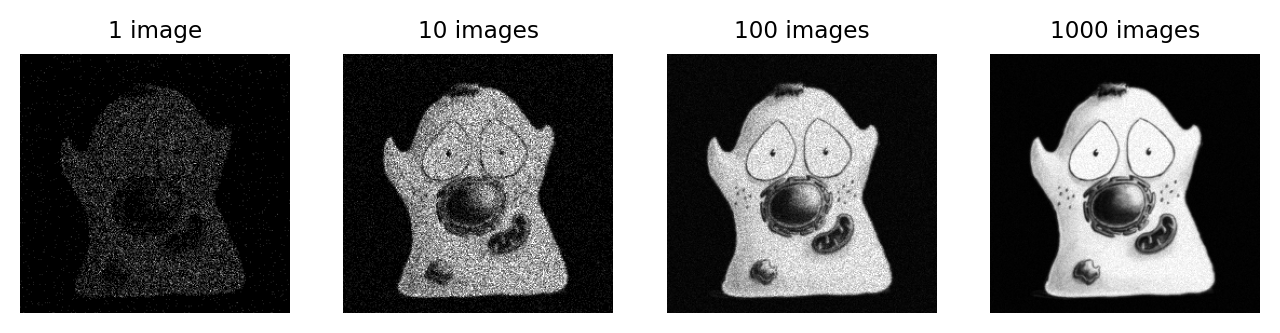

In [12]:
"""
Show impact of adding images with Poisson noise.
"""

im = load_image('happy_cell.tif')
im = im / im.max()

# Create a stack of 1000 images with Poisson noise
rng = np.random.default_rng(200)
noisy_images = np.dstack([rng.poisson(im) for ii in range(1000)])

# Display in a similar way
im_args = dict(clip_percentile=1)

fig = create_figure(figsize=(8, 4))
show_image(noisy_images[:, :, 0], title='1 image', pos=141)
show_image(np.mean(noisy_images[:, :, :10], axis=2), title='10 images', **im_args, pos=142)
show_image(np.mean(noisy_images[:, :, :100], axis=2), title='100 images', **im_args, pos=143)
show_image(np.mean(noisy_images[:, :, :1000], axis=2), title='1000 images', **im_args, pos=144)

glue_fig('fig_noise_averaging', fig)

```{glue:figure} fig_noise_averaging
---
align: center
name: fig-noise_averaging
---
The effect of adding (or averaging) multiple noisy images, each independent with a similar SNR.
```

An alternative would be to increase the pixel size, so that each pixel incorporates photons from larger regions -- although clearly this comes at a cost in spatial information.
One way to do this is though [binning](sec_detectors_binning).

However, noise cannot be completely eliminated during acquisition.
Understanding its behavior, and especially how [filters](chap_filters) can reduce it, can help us cope with it during analysis.

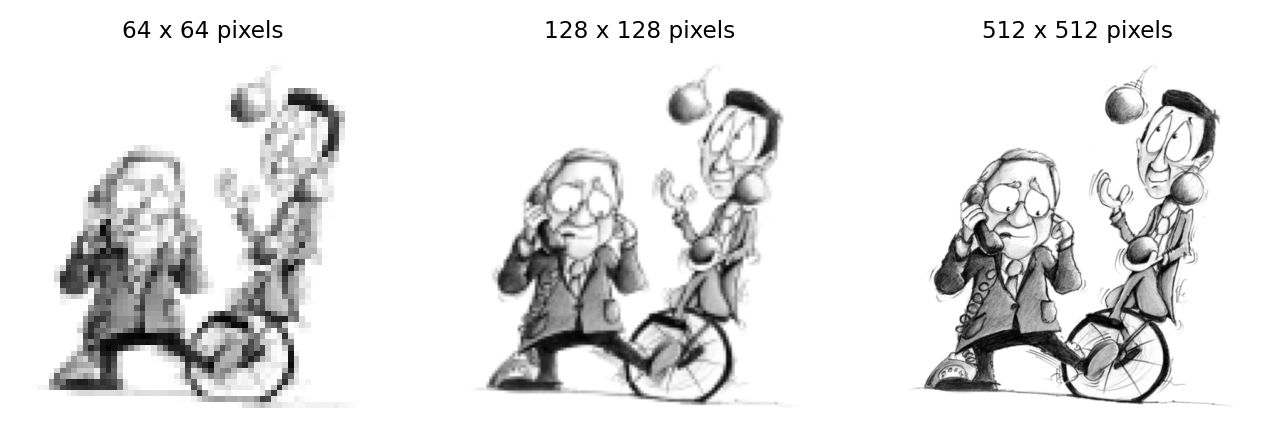

In [13]:
fig = create_figure(figsize=(8, 4))

def bin2x2(im):
    """
    Apply 2x2 binning to the pixels of a 2D image.
    Note that if the dimensions are not even numbers then the final row/column
    of pixels may have to be trimmed.
    """
    r = int(np.floor(im.shape[0]/2)*2)
    c = int(np.floor(im.shape[1]/2)*2)
    return im[0:r:2, 0:c:2] + im[1:r:2, 0:c:2] + im[0:r:2, 1:c:2] + im[1:r:2, 1:c:2]

# Simulate larger bins by progressively applying 2x2 binning
im = load_image('images/nyquist_shannon.png')
assert im.shape == (512, 512)

im = im.astype(np.float32)
im2 = bin2x2(im)
im4 = bin2x2(im2)
im8 = bin2x2(im4)
im16 = bin2x2(im8)

show_image(im8, title='64 x 64 pixels', pos=131)
show_image(im4, title='128 x 128 pixels', pos=132)
show_image(im, title='512 x 512 pixels', pos=133)

glue_fig('fig_noise_nyquist_shannon', fig)

````{admonition} Nyquist sampling & choosing a pixel size

Small pixels are needed to see detail, but also reduce the number of photons per pixel and thereby increase noise.
However, {ref}`chap_formation_spatial` has already argued that ultimately it's not pixel size, but rather the PSF that limits spatial resolution -- which suggests that there is a minimum pixel size below which nothing is gained, and the only result is that more noise is added.

This size can be determined based upon knowledge of the PSF and the **Nyquist-Shannon sampling theorem** ({numref}`fig-nyquist_shannon`).
Images acquired with this pixel size are said to be **Nyquist sampled** (although see Alvy Ray Smith's epic *A Biography of the Pixel* for the case why credit for the sampling theorem really belongs to **Vladimir Kotelnikov**).

The easiest way I know to determine the corresponding pixel size for a given experiment is to use the online calculator provided by *Scientific Volume Imaging* at https://svi.nl/NyquistCalculator.
You may need larger pixels to reduce noise or see a wider field of view, but you do not get anything extra by using smaller pixels.

```{glue:figure} fig_noise_nyquist_shannon
---
align: center
name: fig-nyquist_shannon
---
Harry Nyquist (1889-1975) and Claude Shannon (1916-2001), sampled using different pixel sizes.
Their work is used when determining the pixel sizes needed to maximize the available information when acquiring images, which depends upon the size of the PSF.
```
````